In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
from pathlib import Path
import itertools
import functools
from collections import namedtuple, Counter
import re
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import read_vocab, PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID, IMAGE_H, IMAGE_W
from multimodal.multimodal_saycam_data_module import VOCAB_FILENAME
from ngram import NGramModel
from multimodal.utils import map_structure
from analysis_tools.processing import *
from analysis_tools.utils import *
from analysis_tools.sentences_data import *
from analysis_tools.sentences_utils import *
from analysis_tools.checkpoints import *
from analysis_tools.build_data import *


ZORRO_TXT_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/Zorro/sentences/babyberta/")
ZORRO_TXT_FILES = ZORRO_TXT_DIR.glob('*.txt')
TOKENIZED_DIR = Path("tokenized_Zorro_sentences")
N_MAX_PRINT_OOV_SENT_PAIRS = 15


figsize = (13, 12)
sns.set_theme(
    style='white',
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'ytick.left': False,
        'ytick.right': False,
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

np.set_printoptions(suppress=True, precision=2, linewidth=120)
pd.options.display.width = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def sentence_pair_in_vocab(sentence_pair, vocab):
    for sentence in sentence_pair:
        if not all(str(token) in vocab for token in sentence):
            return False
    return True


def prepend_image_placeholder_for_batch(batch):
    batch_size = len(batch[0])
    x = torch.zeros(batch_size, 3, IMAGE_H, IMAGE_W, dtype=torch.float, device=device)
    return x, *batch

In [3]:
# get SAYCam vocab
saycam_vocab = read_vocab(VOCAB_FILENAME)
saycam_vocab_size = len(saycam_vocab)
print(f'{saycam_vocab_size = }')
word2idx = saycam_vocab
idx2word = [None] * saycam_vocab_size
for word, idx in word2idx.items():
    idx2word[idx] = word
idx2word = np.array(idx2word)

# get Zorro data
zorro_data = {}
zorro_vocab = Counter()

for zorro_txt_file in ZORRO_TXT_FILES:
    data_name = tuple(zorro_txt_file.stem.split('-'))
    print(f'processing {zorro_txt_file.stem} ...', end='', flush=True)

    tokenized_file = TOKENIZED_DIR / (zorro_txt_file.stem + '.pkl')

    if tokenized_file.exists():
        print(f' load from {tokenized_file}')
        with open(tokenized_file, 'rb') as f:
            sentences = pickle.load(f)

    else:
        with open(zorro_txt_file, 'r') as f:
            sentences = [tokenize(line.strip()) for line in f]

        print(f' save to {tokenized_file}')
        tokenized_file.parent.mkdir(parents=True, exist_ok=True)
        with open(tokenized_file, 'wb') as f:
            pickle.dump(sentences, f)

    zorro_data[data_name] = sentences

    zorro_vocab.update(map(str, itertools.chain.from_iterable(sentences)))

# Zorro vocab
zorro_vocab = sorted(
    zorro_vocab.items(),
    key = lambda item: (-item[1], item[0])
)
zorro_vocab_size = len(zorro_vocab)
print(f'{zorro_vocab_size = }')
print('words in zorro vocab:')
for word, freq in zorro_vocab[:100]:
    print(f'{word:10} {freq:6}')

# Zorro vocab compared to SAYCam vocab
in_saycam_vocab_cnt = 0
print('words not in SAYCam vocab:')
for word, freq in zorro_vocab:
    if word in saycam_vocab:
        in_saycam_vocab_cnt += 1
    else:
        print(word)
print(f'{frac_format(in_saycam_vocab_cnt, len(zorro_vocab))} in SAYCam vocab')

# filter Zorro data
filter_masks = {}

for data_name, sentences in zorro_data.items():
    n_total = 0
    sentence_pairs_in_saycam_vocab, sentence_pairs_out_of_saycam_vocab, filter_mask = [], [], []

    print('out-of-SAYCam vocab sentence examples:')
    for sentence_pair in paired(sentences):
        n_total += 1

        filter_flag = sentence_pair_in_vocab(sentence_pair, saycam_vocab)
        filter_mask.append(filter_flag)

        if filter_flag:
            sentence_pairs_in_saycam_vocab.append(sentence_pair)
        else:
            sentence_pairs_out_of_saycam_vocab.append(sentence_pair)
            if len(sentence_pairs_out_of_saycam_vocab) <= N_MAX_PRINT_OOV_SENT_PAIRS:
                for sentence in sentence_pair:
                    print(untokenize(sentence))
                print(
                    'OOV tokens:',
                    ' '.join(
                        str(token)
                        for sentence in sentence_pair
                        for token in sentence
                        if str(token) not in saycam_vocab
                    )
                )

    print(f'{data_name}: {frac_format(len(sentence_pairs_in_saycam_vocab), n_total)}')

    filter_masks[data_name] = filter_mask

saycam_vocab_size = 2350
processing agreement_determiner_noun-across_1_adjective ... load from tokenized_Zorro_sentences/agreement_determiner_noun-across_1_adjective.pkl
processing agreement_determiner_noun-between_neighbors ... load from tokenized_Zorro_sentences/agreement_determiner_noun-between_neighbors.pkl
processing agreement_subject_verb-across_prepositional_phrase ... load from tokenized_Zorro_sentences/agreement_subject_verb-across_prepositional_phrase.pkl
processing agreement_subject_verb-across_relative_clause ... load from tokenized_Zorro_sentences/agreement_subject_verb-across_relative_clause.pkl
processing agreement_subject_verb-in_question_with_aux ... load from tokenized_Zorro_sentences/agreement_subject_verb-in_question_with_aux.pkl
processing agreement_subject_verb-in_simple_question ... load from tokenized_Zorro_sentences/agreement_subject_verb-in_simple_question.pkl
processing anaphor_agreement-pronoun_gender ... load from tokenized_Zorro_sentences/anaphor_agreement

('argument_structure', 'transitive'): 384 / 2000 = 19.20%
out-of-SAYCam vocab sentence examples:
Ben thinks about himself called this fuel .
Ben thinks about himself calling this fuel .
OOV tokens: Ben thinks fuel Ben thinks calling fuel
Anne thinks about herself called this fuel .
Anne thinks about herself calling this fuel .
OOV tokens: Anne thinks herself fuel Anne thinks herself calling fuel
Ben thinks about himself gets this fuel .
Ben thinks about himself getting this fuel .
OOV tokens: Ben thinks fuel Ben thinks fuel
Anne thinks about herself gets this fuel .
Anne thinks about herself getting this fuel .
OOV tokens: Anne thinks herself fuel Anne thinks herself fuel
Roger thinks about himself tried this stand .
Roger thinks about himself trying this stand .
OOV tokens: Roger thinks Roger thinks
Laura thinks about herself tried this stand .
Laura thinks about herself trying this stand .
OOV tokens: Laura thinks herself Laura thinks herself
Roger thinks about himself makes this sta

In [7]:
# build datasets
datasets = {
    data_name: SentencesDataset(sentences, saycam_vocab)
    for data_name, sentences in zorro_data.items()
}

my_batch_size = 256


# load model from checkpoint

# select from list of checkpoints
dataset_name = "saycam"
names = [
    "lm0", #"lm1", "lm2",
    "cbow0", #"cbow1", "cbow2",
    "1-gram", "2-gram", "3-gram", "4-gram",
]
dataset_checkpoint_paths = all_checkpoint_paths[dataset_name]
checkpoint_paths = [dataset_checkpoint_paths[name] for name in names]

models = []

saycam_data = None

for checkpoint_path in checkpoint_paths:
    if "gram" in checkpoint_path:
        ngram_model = build_ngram_model(int(checkpoint_path.split('-')[0]), saycam_vocab_size, saycam_data.train_dataloader())
        model = ngram_model

    else:
        print(f"load model from {checkpoint_path}")
        lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
        lit_model.to(device)
        lit_model.eval()
        model = lit_model

        if saycam_data is None:
            # build data and vocab according to the model
            saycam_data, args = build_data(args=lit_model.args, return_args=True)
            dataset_name = args.dataset

        else:
            assert lit_model.args["dataset"] == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

    models.append(model)

load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Using base transforms
Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created. Skipping this step.
Shuffled training metadata file has already been created. Skipping this step.
Evaluation frames have already been filtered. Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Filtered evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Vocabulary file already exists. Skipp

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2108/2108 [00:28<00:00, 74.52it/s]


In [5]:
loss_dfs = {
    data_name: pd.DataFrame(np.zeros((len(dataset), 0)))
    for data_name, dataset in datasets.items()
}


for model_name, model in zip(names, models):
    print(f'running {model_name} ...')
    for data_name, dataset in datasets.items():
        if not dataset:
            continue
        dataloader = DataLoader(
            dataset,
            collate_fn=collate_fn,
            shuffle=False,
            batch_size=my_batch_size,
            drop_last=False,
        )
        batches = map(prepend_image_placeholder_for_batch, dataloader)
        losses = get_model_losses_on_data_batches(model, batches, use_tqdm=False)
        losses = losses.cpu().numpy()
        loss_dfs[data_name][f'SAYCam {model_name}'] = losses

for probing_results_dir in Path('/misc/vlgscratch4/LakeGroup/wentao/BabyBERTa/probing_results/babyberta').glob('*'):
    model_name = probing_results_dir.name
    if model_name not in ['BabyBERTa_AO-CHILDES', 'BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1']:
        continue
    for file in probing_results_dir.glob('*'):
        stem = file.stem
        data_name = tuple(stem.split('-'))
        sentences, losses = zip(*read_sentences_and_losses(file))
        loss_dfs[data_name][model_name] = losses

running lm0 ...
running cbow0 ...
running 1-gram ...
running 2-gram ...
running 3-gram ...
running 4-gram ...


/home/ww2135/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


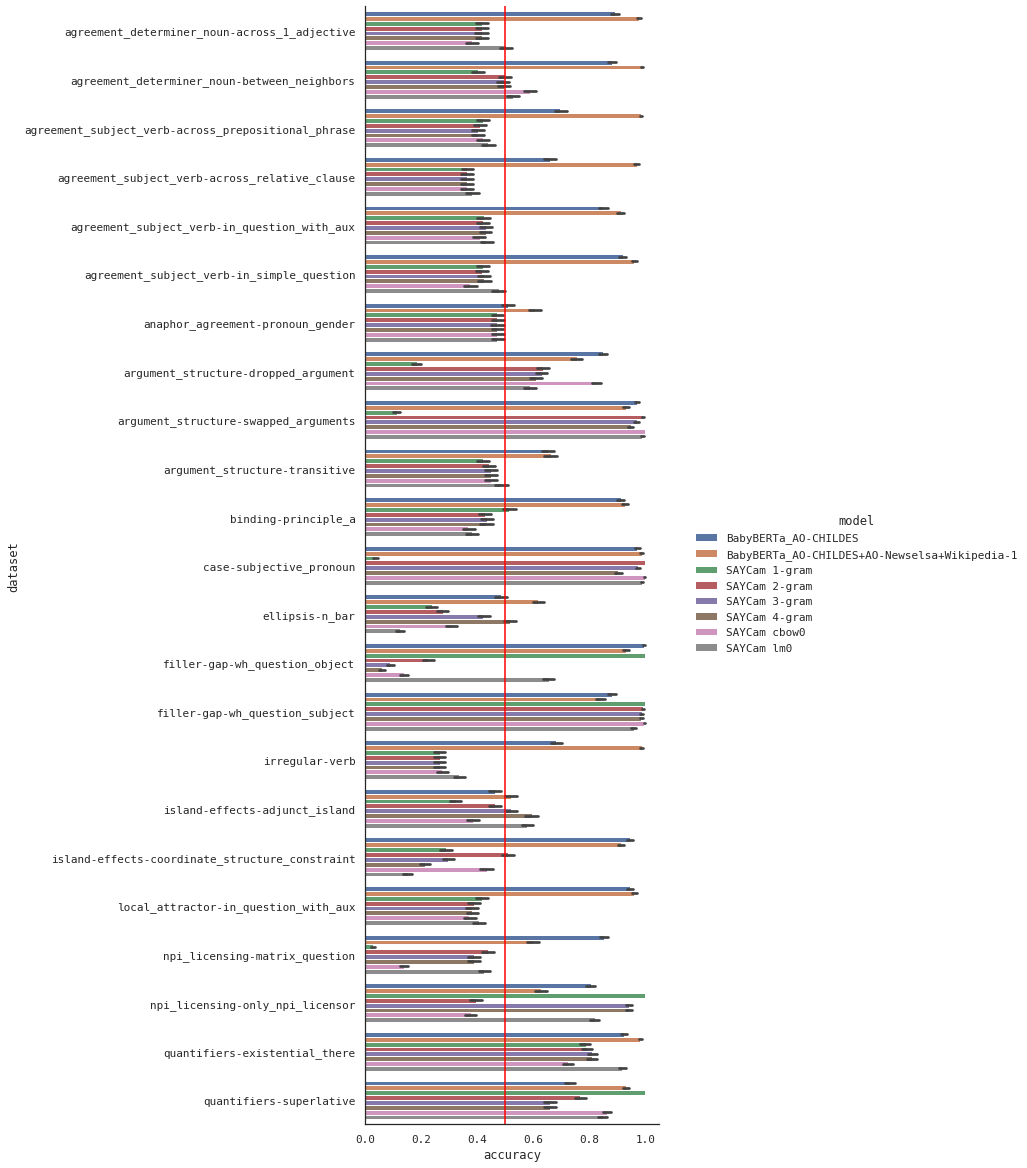

                                                                                                 accuracy
model                                        dataset                                                     
BabyBERTa_AO-CHILDES                         agreement_determiner_noun-across_1_adjective          0.8915
                                             agreement_determiner_noun-between_neighbors           0.8805
                                             agreement_subject_verb-across_prepositional_phrase    0.6965
                                             agreement_subject_verb-across_relative_clause         0.6590
                                             agreement_subject_verb-in_question_with_aux           0.8495
                                             agreement_subject_verb-in_simple_question             0.9185
                                             anaphor_agreement-pronoun_gender                      0.5085
                                             a

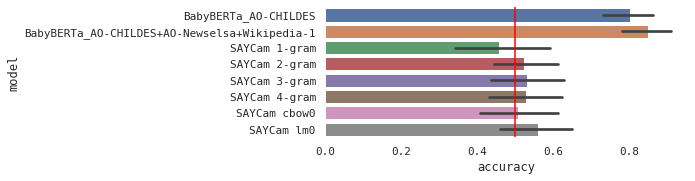

                                              accuracy
model                                                 
BabyBERTa_AO-CHILDES                          0.803043
BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1  0.851000
SAYCam 1-gram                                 0.458304
SAYCam 2-gram                                 0.522283
SAYCam 3-gram                                 0.531457
SAYCam 4-gram                                 0.529174
SAYCam cbow0                                  0.507022
SAYCam lm0                                    0.560587


/home/ww2135/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


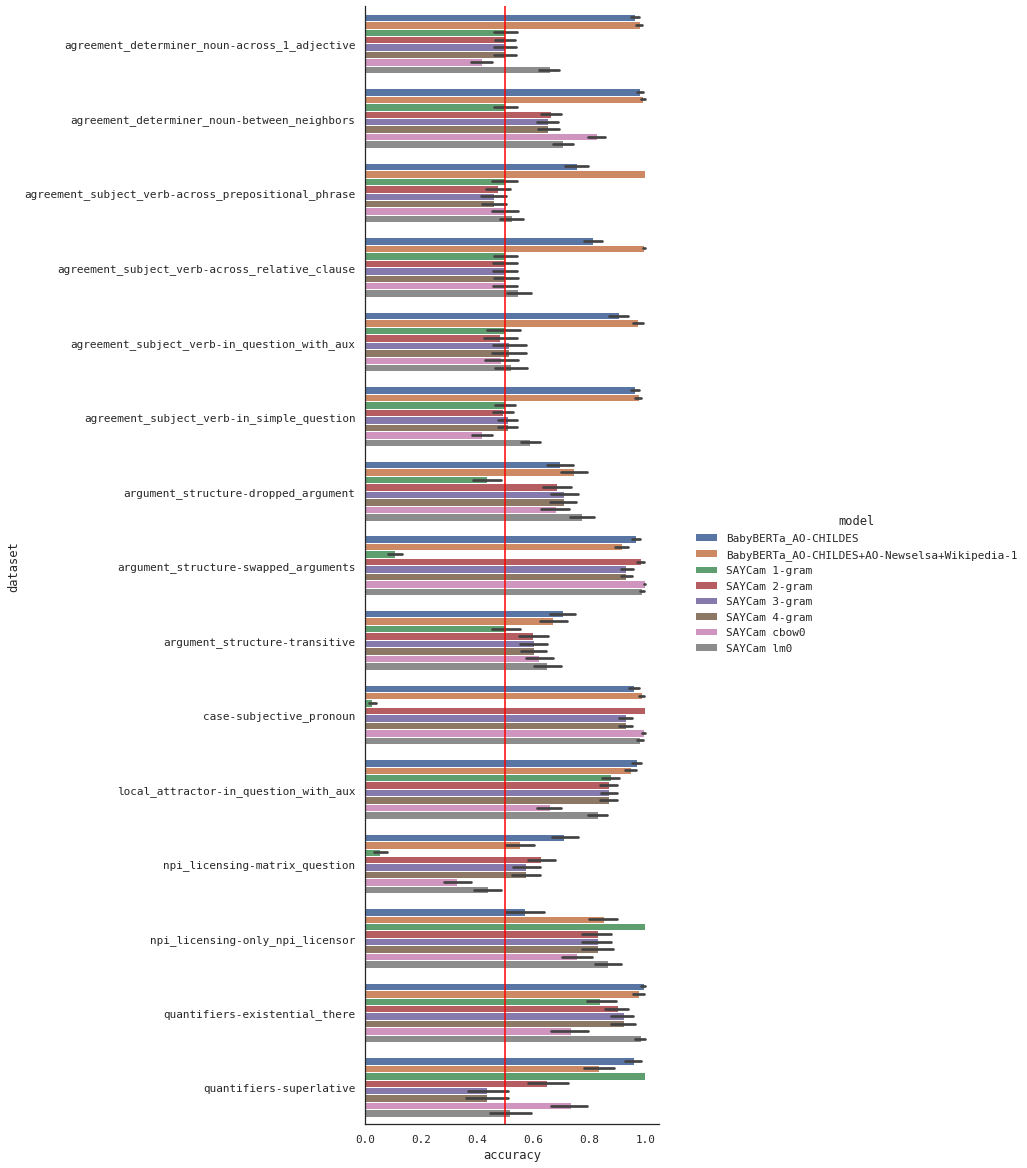

                                                                                                 accuracy
model                                        dataset                                                     
BabyBERTa_AO-CHILDES                         agreement_determiner_noun-across_1_adjective        0.963415
                                             agreement_determiner_noun-between_neighbors         0.980519
                                             agreement_subject_verb-across_prepositional_phrase  0.756250
                                             agreement_subject_verb-across_relative_clause       0.812030
                                             agreement_subject_verb-in_question_with_aux         0.907143
                                             agreement_subject_verb-in_simple_question           0.964115
                                             argument_structure-dropped_argument                 0.695015
                                             a

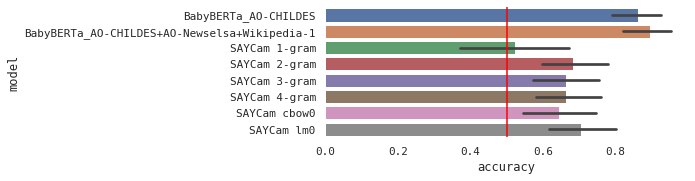

                                              accuracy
model                                                 
BabyBERTa_AO-CHILDES                          0.860991
BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1  0.893722
SAYCam 1-gram                                 0.522499
SAYCam 2-gram                                 0.683893
SAYCam 3-gram                                 0.662770
SAYCam 4-gram                                 0.662770
SAYCam cbow0                                  0.643357
SAYCam lm0                                    0.704908


In [6]:
def get_correct_df(loss_df):
    sub_loss_dfs = [loss_df.iloc[i::2].reset_index(drop=True) for i in range(2)]
    return sub_loss_dfs[0] > sub_loss_dfs[1]


correct_dfs = {
    data_name: get_correct_df(loss_df)
    for data_name, loss_df in loss_dfs.items()
}

filtered_correct_dfs = {
    data_name: correct_df.iloc[filter_masks[data_name]]
    for data_name, correct_df in correct_dfs.items()
}


for current_correct_dfs in [correct_dfs, filtered_correct_dfs]:
    data_names = list(current_correct_dfs.keys())
    df = pd.concat(
        [current_correct_dfs[data_name] for data_name in data_names],
        keys=list(map('-'.join, data_names)),
        names=['dataset', 'idx'],
    )
    df = df.reset_index()
    df = df.melt(id_vars=['dataset', 'idx'], var_name='model', value_name='accuracy')

    hue_order = sorted(set(df['model']))

    g = sns.catplot(kind="bar", data=df, x='accuracy', y='dataset', hue='model', hue_order=hue_order)
    g.figure.set_size_inches(figsize[0] * 0.8, figsize[1] * 1.5)
    plt.gca().axvline(0.5, color='red')
    plt.show()

    model_dataset_mean_df = df.drop(labels='idx', axis=1).groupby(by=['model', 'dataset']).mean()
    print(model_dataset_mean_df.to_string())

    model_dataset_mean_long_df = model_dataset_mean_df.reset_index()
    g = sns.barplot(data=model_dataset_mean_long_df, x='accuracy', y='model', order=hue_order)
    g.figure.set_size_inches(figsize[0] * 0.5, figsize[1] * 0.2)
    plt.gca().axvline(0.5, color='red')
    plt.show()

    model_mean_df = model_dataset_mean_df.groupby(level='model').mean()
    print(model_mean_df.to_string())